# [MATH2504 Programming of Simulation, Analysis, and Learning Systems at The University of Queensland](https://courses.smp.uq.edu.au/MATH2504/)

## Semester 2, 2025

# Practical F: Towards project 2

In this practical we work towards project 2 by considering design patterns used in a discrete event simulation engines.


**The code in the cell below is from Unit 7.** It can serve as a basis for complex discrete event simulations. 

In [1]:
using DataStructures
import Base: isless

abstract type Event end
abstract type State end

#Captures an event and the time it takes place
struct TimedEvent
    event::Event
    time::Float64
end

#Comparison of two timed events - this will allow us to use them in a heap/priority-queue
isless(te1::TimedEvent, te2::TimedEvent) = te1.time < te2.time

#This is an abstract function 
"""
It will generally be called as 
       new_timed_events = process_event(time, state, event)
It will generate 0 or more new timed events based on the current event
"""
function process_event end

#Generic events that we can always use
struct EndSimEvent <: Event end
struct LogStateEvent <: Event end

function process_event(time::Float64, state::State, es_event::EndSimEvent)
    println("Ending simulation at time $time.")
    return []
end

function process_event(time::Float64, state::State, ls_event::LogStateEvent)
    println("Logging state at time $time.")
    println(state)
    return []
end;

"""
The main simulation function gets an initial state and an initial event that gets things going.
Optional arguments are the maximal time for the simulation, times for logging events, and a call back function.
"""
function do_sim(init_state::State, init_timed_event::TimedEvent
                    ; 
                    max_time::Float64 = 10.0, 
                    log_times::Vector{Float64} = Float64[],
                    call_back = (time, state) -> nothing)

    #The event queue
    priority_queue = BinaryMinHeap{TimedEvent}()

    #Put the standard events in the queue
    push!(priority_queue, init_timed_event)
    push!(priority_queue, TimedEvent(EndSimEvent(), max_time))
    for lt in log_times
        push!(priority_queue,TimedEvent(LogStateEvent(), lt))
    end

    #initilize the state
    state = deepcopy(init_state)
    time = 0.0

    call_back(time, state)

    #The main discrete event simulation loop - SIMPLE!
    while true
        #Get the next event
        timed_event = pop!(priority_queue)

        #advance the time
        time = timed_event.time

        #Act on the event
        new_timed_events = process_event(time, state, timed_event.event) 

        #if the event was an end of simulation then stop
        isa(timed_event.event, EndSimEvent) && break 

        #The event may spawn 0 or more events which we put in the priority queue 
        for nte in new_timed_events
            push!(priority_queue, nte)
        end

        call_back(time, state)
    end
end;

In the Unit 7 lectures you see how to implement a simple M/D/1 queue based on the framework above. We'll now use this framework for a more complicated queueing system which is slightly closer to Project 2. We'll consider a **tandem queueing system** which is a sequence of queues where jobs arrive externally to the first queue and after service go to the second queue, and so fourth until exiting from the final queue and leaving the system.

The systems is already coded, but as part of the practical we'll use the code to experiment. The code can help with Project 2 as well.

We also introduce an additional type, `TandemNetworkParameters` which is used to store the general parameters of the system. Nodes in the system are numbered 1,...,`num_nodes`. Each node has a service rate (inverse of the mean) from `μ_array` and has a squared coefficient of variation (SCV) from `scv_array`. We use Gamma random variables.

### SCV, Exponential, and Gamma random variables

**Note: For 2024 you can skim through details for the SCV and Gamma distribution as it is not in Project 2 this year.**

The SCV of a random variable is its variance divided by the mean squared. It is a normalized measure of the variability of the random variable. Exponential random variables have an SCV of $1$:

In [2]:
using Distributions

dist = Exponential(22.3)
scv(d)= var(d)/mean(d)^2
scv(dist)

1.0

In [3]:
#Exponential is a special case of Gamma with shape = 1
dist = Gamma(1,22.3)
scv(dist)

1.0

In [4]:
? Gamma #Note that sometimes the gamma distribution is parameterized not by scale but by rate (inverse of scale)

search: Gamma InverseGamma



```
Gamma(α,θ)
```

The *Gamma distribution* with shape parameter `α` and scale `θ` has probability density function

$$
f(x; \alpha, \theta) = \frac{x^{\alpha-1} e^{-x/\theta}}{\Gamma(\alpha) \theta^\alpha},
\quad x > 0
$$

```julia
Gamma()          # Gamma distribution with unit shape and unit scale, i.e. Gamma(1, 1)
Gamma(α)         # Gamma distribution with shape α and unit scale, i.e. Gamma(α, 1)
Gamma(α, θ)      # Gamma distribution with shape α and scale θ

params(d)        # Get the parameters, i.e. (α, θ)
shape(d)         # Get the shape parameter, i.e. α
scale(d)         # Get the scale parameter, i.e. θ
```

External links

  * [Gamma distribution on Wikipedia](http://en.wikipedia.org/wiki/Gamma_distribution)


In [5]:
dist = Gamma(2,3) #Shape of 2 and scale of 3

Gamma{Float64}(α=2.0, θ=3.0)

In [6]:
mean(dist) #The mean is shape*scale 

6.0

In [7]:
var(dist) #The variance is shape*scale^2

18.0

Hence for a gamma distribution  SCV = 1/shape.

In [8]:
dist = Gamma(0.1,3)
round(scv(dist), digits = 5)

10.0

In [9]:
#This is convenient in the queueing context

"""
A convenience function to make a Gamma distribution with desired rate (inverse of shape) and SCV.
"""
rate_scv_gamma(desired_rate::Float64, desired_scv::Float64) = Gamma(1/desired_scv, desired_scv/desired_rate)

dist = rate_scv_gamma(3., 0.5)
@show mean(dist)
@show scv(dist);

mean(dist) = 0.3333333333333333
scv(dist) = 0.5


In [10]:
dist

Gamma{Float64}(α=2.0, θ=0.16666666666666666)

# We now construct the tandem queueing network

In [11]:
struct TandemNetworkParameters
    num_nodes::Int              # The number of nodes (queues/servers) in the system
    λ::Float64                  # The external arrival rate to the first queue
    μ_array::Vector{Float64}    # The list of the rates of service in each of the queues.
    scv_array::Vector{Float64}  # A list of the squared coefficients of service times.
end

In [12]:
mutable struct TandemQueueNetworkState <: State
    queues::Vector{Int}             #A vector which indicates the number of customers in each queue
    params::TandemNetworkParameters #The parameters of the tandem queueing system
end
 
#External arrival to the firt queue
struct ExternalArrivalEvent <: Event end
 
struct EndOfServiceAtQueueEvent <: Event
    q::Int #The index of the queue where service finished
end

In [13]:
total_in_system(state::TandemQueueNetworkState) = sum(state.queues)

total_in_system (generic function with 1 method)

These two functions help generate random variables.

In [14]:
next_arrival_duration(s::State) = rand(Exponential(1/s.params.λ))
next_service_duration(s::State, q::Int) = rand(rate_scv_gamma(s.params.μ_array[q], s.params.scv_array[q]));

This is the main logic of the simulation.

**Note:** There is a **BUG** in one of these two functions below and this will cause the theoretical and simulation results to **not** agree. See end of prac.

In [15]:
function process_event(time::Float64, state::State, arrival_event::ExternalArrivalEvent)
    state.queues[1] += 1     #increase number in first queue
    new_timed_events = TimedEvent[]
 
    #prepare next arrival
    push!(new_timed_events, TimedEvent(ExternalArrivalEvent(), time + next_arrival_duration(state)))
 
    #if this is the only job on the server engage service
    state.queues[1] == 1 && push!(new_timed_events,
                                TimedEvent(EndOfServiceAtQueueEvent(1), time + next_service_duration(state,1)))
    return new_timed_events
end
 
#Process an end of service event
function process_event(time::Float64, state::State, eos_event::EndOfServiceAtQueueEvent)
    q = eos_event.q
    new_timed_events = TimedEvent[]
    
    state.queues[q] -= 1
    @assert state.queues[q] ≥ 0
    
    #if another customer in the queue then start a new service
    if state.queues[q] ≥ 1
        st = next_service_duration(state, q)
        push!(new_timed_events, TimedEvent(EndOfServiceAtQueueEvent(q), time + st)) 
    end
    
    #If there is a downstream queue
    if q < state.params.num_nodes
        state.queues[q+1] += 1 #move the job to the downstream queue
        
        #if the queue downstream was empty
        if state.queues[q+1] == 1 
            st = next_service_duration(state, q) ##### Bug is here... what is the fix?
            push!(new_timed_events, TimedEvent(EndOfServiceAtQueueEvent(q+1), time + st)) 
        end
    end
    
    return new_timed_events
end

process_event (generic function with 4 methods)

# Experimenting with the simulation

We can now use the simulation code above to experiment.

## A Short animation

In [16]:
#This function runs the simulation and records a full trajectory
function do_experiment_traj(;   n=10, 
                                max_time = 100.0, 
                                scv = 1.5, 
                                λ = 1.0, 
                                μ_possibilities = [1.05, 2.0, 3.0, 4.0])
    time_traj, queues_traj = Float64[], Vector{Int}[]

    function record_traj(time::Float64, state::TandemQueueNetworkState) 
        #println("time = $time, $(state.queues)")
        push!(time_traj, time)
        push!(queues_traj, copy(state.queues))
        return nothing
    end

    pars = TandemNetworkParameters(n, λ, rand(μ_possibilities, n), fill(scv,n))
    init_queues = fill(0,n)
    do_sim( TandemQueueNetworkState(init_queues, pars), 
            TimedEvent(ExternalArrivalEvent(),0.0), 
            max_time = max_time, 
            call_back = record_traj)
    
    return time_traj, queues_traj, pars
end

do_experiment_traj (generic function with 1 method)

In [17]:
using Random
Random.seed!(0)
time, traj, pars = do_experiment_traj();

Ending simulation at time 100.0.


In [18]:
#The load on each individual queue is the external arrival rate divided by the service rate (as long as <1)
ρ_loads = pars.λ ./ pars.μ_array

10-element Vector{Float64}:
 0.5
 0.9523809523809523
 0.25
 0.9523809523809523
 0.3333333333333333
 0.9523809523809523
 0.9523809523809523
 0.3333333333333333
 0.5
 0.9523809523809523

In [19]:
length(time) #number of events in simulation

831

In [20]:
using Plots

function create_anim(time, traj, ρ_loads)
    mm = maximum(maximum.(traj))
    
    n = length(time)
    @assert length(traj) == n
    anim = Animation()
    for i in 1:n
        plot(ρ_loads*1.2*mm,label = "Relative Load") #The load on each queue (stretched to the top of the plot)
        plot!(traj[i],line = :stem, lw = 10, 
            label=false, title="Time = $(round(time[i],digits=2))",
            ylim = (0,1.2*mm), xlabel = "Queue index", ylabel="Number in queue",yticks = 0:(floor(Int,1.2*mm)))
        frame(anim)
    end
    gif(anim, "graph.gif", fps = 20)
end

create_anim (generic function with 1 method)

[ Info: Saved animation to /Users/uqjnazar/git/ProgrammingCourse-with-Julia-SimulationAnalysisAndLearningSystems/practicals_jupyter/graph.gif


Plots.AnimatedGif("/Users/uqjnazar/git/ProgrammingCourse-with-Julia-SimulationAnalysisAndLearningSystems/practicals_jupyter/graph.gif")
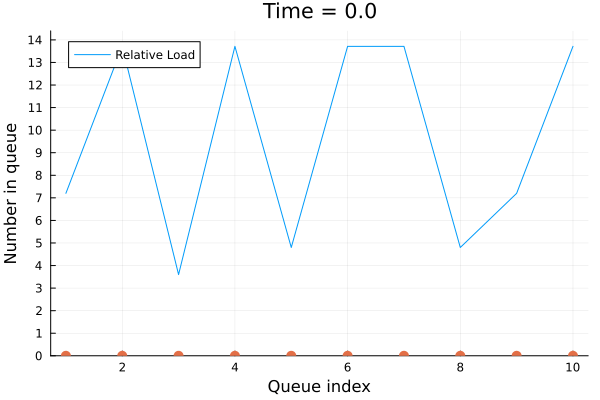

In [21]:
create_anim(time, traj, ρ_loads)

**Above:** An animation of the tandem queueing network starting empty. The load on each queue is also plotted (the magnitude of it is meaningless - only the relative magnitude is important). It can be seen that queues tend to "build up" where the the load is high.

## Long time horizon simulation

In [22]:
#This function runs the simulation and records a full trajectory
function do_experiment_long(;n=5, warm_up_time = 1e5, 
                            max_time = 1e6, scv = 1.0, 
                            λ = 1.0, μ_possibilities = [1.5, 2.0, 3.0])
    queues_integral = zeros(n)
    last_time = 0.0
    
    function record_integral(time::Float64, state::TandemQueueNetworkState) 
        (time ≥ warm_up_time) && (queues_integral += state.queues*(time-last_time)) #Use a warmup time
        last_time = time
        return nothing
    end

    pars = TandemNetworkParameters(n, λ, rand(μ_possibilities,n), fill(scv,n))
    init_queues = fill(0,n)
    do_sim(TandemQueueNetworkState(init_queues, pars), 
        TimedEvent(ExternalArrivalEvent(),0.0), max_time = max_time, call_back = record_integral)
    queues_integral/(max_time-warm_up_time), pars
end

do_experiment_long (generic function with 1 method)

In [23]:
using Random
Random.seed!(1)
queue_means, pars = do_experiment_long();

Ending simulation at time 1.0e6.


In [24]:
#The load on each individual queue is the external arrival rate divided by the service rate (as long as <1)
ρ_loads = round.(pars.λ ./ pars.μ_array,digits=8);

If all nodes have SCV=1.0 and for all nodes the load is less then 1, then there is a theoretical mean from queueing theory:

In [25]:
theor_mean(ρ) = round(ρ/(1-ρ),digits=3);

In [26]:
theor_means = theor_mean.(ρ_loads);

In [27]:
# import Pkg; Pkg.add("PrettyTables")

In [28]:
using PrettyTables
pretty_table(hcat(ρ_loads, theor_means, round.(queue_means,digits=3) ), header = ["ρ", "Theory", "Sim"] )

┌──────────┬────────┬───────┐
│        ρ │ Theory │   Sim │
├──────────┼────────┼───────┤
│ 0.666667 │    2.0 │ 2.037 │
│      0.5 │    1.0 │ 1.254 │
│ 0.333333 │    0.5 │  0.75 │
│      0.5 │    1.0 │ 0.799 │
│ 0.333333 │    0.5 │ 0.708 │
└──────────┴────────┴───────┘


**Note:** You'll notice that the theoretical results and the simulation results **do not** agree. Even if you increase the simulation time that is still the case. There is a bug in the simulation code. Try to find it with inspection. It is a simple fix in one line. Once you fix it, if you run the simulation again, the theoretical and simulation results will agree.